### Deep Learning - Project 21
#### Week 3:
This week we are going to use the model weights trained for the SIMUPOR dataset and use the model on the tomography data: first on the labelled data and then to generate pseudo-labels for the unlabelled data.

In [1]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, UnidentifiedImageError
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, random_split, DataLoader
from scipy.ndimage import gaussian_filter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter, map_coordinates
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Step 0:
Some steps from the previous notebook that we need to also add.

In [3]:
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)
        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        return out

def dice_loss(pred, target, smooth = 1.0):  #metric that prioritizes overlap between predictions and targets
    """
    Computes the Dice Loss for binary segmentation.
    Args:
        pred: Tensor of predictions (batch_size, 1, H, W).
        target: Tensor of ground truth (batch_size, 1, H, W).
        smooth: Smoothing factor to avoid division by zero.
    Returns:
        Scalar Dice Loss.
    """
    # Apply sigmoid to convert logits to probabilities
    pred = torch.sigmoid(pred)

    # Calculate intersection and union
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    # Compute Dice Coefficient
    dice = (2. * intersection + smooth) / (union + smooth)

    # Return Dice Loss
    return 1 - dice.mean()

bce = nn.BCEWithLogitsLoss() # combines a Sigmoid layer and the Binary Cross Entropy between the target and the input probabilities

# we combine the dice loss and the bce loss
def combined_loss(pred, target, alpha=0.5):
    """
    alpha: weight for Dice vs CE
    """
    return alpha * dice_loss(pred, target) + (1 - alpha) * bce(pred, target)

def dice_coefficient(pred, target):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection) / (union + 1e-6)
    return dice.item()

def iou_score(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + eps) / (union + eps)

#### Step 1:
Adapt existing model to the tomography data. This new data has four labels and way bigger size. We will group pores as one label (sometimes they are in gray and others in black) and background and cracks as one label.

In [25]:
# Uploading the weights from Drive
weights_path = "/content/drive/MyDrive/SIMUPOR/unet_simupor_weights.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Creates a new model and uploads the weights to it
model = UNet(num_classes=1).to(device)

state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

print("Weights loaded successfully")

Weights loaded successfully


Download the images and masks.

In [4]:
# Paths to files where images are
labelled_images_path = "/content/drive/MyDrive/dl_p21_data/labelled_data/images"
labelled_masks_path  = "/content/drive/MyDrive/dl_p21_data/labelled_data/masks"
unlabelled_images_path_1h = "/content/drive/MyDrive/dl_p21_data/unlabelled_data/1h_HT"
unlabelled_images_path_10min = "/content/drive/MyDrive/dl_p21_data/unlabelled_data/10min_HT"

# All the images inside each path (TIFF files)
labelled_image_files = sorted(os.listdir(labelled_images_path))
labelled_mask_files  = sorted(os.listdir(labelled_masks_path))
unlabelled_image_files_1h = sorted(os.listdir(unlabelled_images_path_1h))
unlabelled_image_files_10min = sorted(os.listdir(unlabelled_images_path_10min))

#####
We need to load the new data (labelled and unlabelled) and do normalization/denoising. Image resolution is 22 nm, so using denoising with sigma = 1 is enough to highlight edges (one pixel equals 66 nm blur radius)  In order to make the mask binary we can choose to do otsu tresholding (dynamic tresholding that is very helpful - chooses treshold with lowest combined variance for each image). Otsu tresholding still shows some very small pores that aren't in the image, because the pores are in black in the image, some high intensity pixels get mistaken for labels. But in the masks we can see that the background class is actually just the background of the original image. So to better the Otsu tresholding we decided to try a guided Otsu that uses as a refrence the original image. We haven't seen any examples of this tecnique before, but seems to work very well. We also tried to simply keep the mask pixels that have a higher intensity than those of the original image which worked very well, removing the high intensity pixels that got mistaken for labels. But it kept in the mask cracks that were labeled in gray, which is problematic. The tecnique used at the end was a internsection between the guided otsu (doesn't highlight cracks) and the background removal (doesn't highlight high intensity pores). The code to visualize different tresholding methods is below (to better choose them)

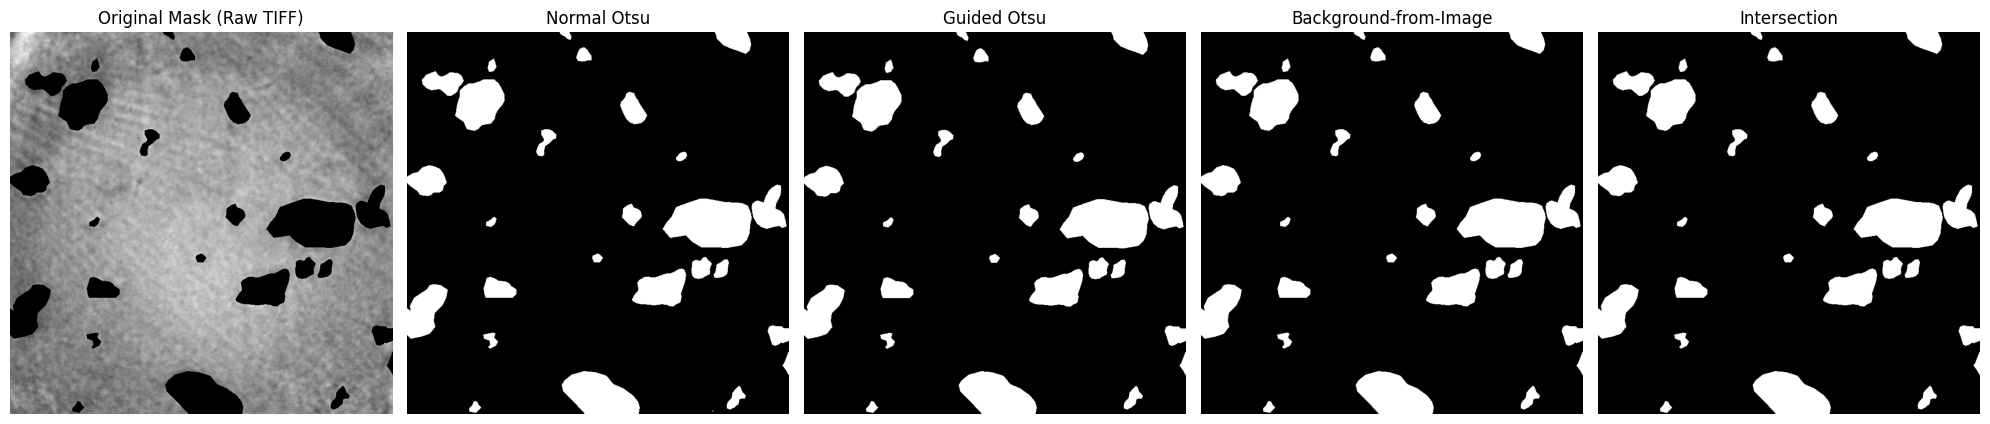

In [7]:
# Pick a single labelled image for visualization
idx = np.random.randint(0, len(labelled_image_files))
mask_vis_raw   = tiff.imread(os.path.join(labelled_masks_path, labelled_mask_files[idx])).astype(np.float32)
image_vis      = tiff.imread(os.path.join(labelled_images_path, labelled_image_files[idx])).astype(np.float32)

# Normal Otsu
def normal_otsu(mask_np):
    t = threshold_otsu(mask_np)
    binary_mask = (mask_np > t).astype(np.uint8)
    binary_mask = 1 - binary_mask
    return binary_mask

# Removing the pixels that are lighter than the background
def background_from_image(img_np, mask_np):
    binary_mask = (mask_np < img_np).astype(np.uint8)
    return binary_mask

# Guided Otsu
def guided_otsu(img_np, mask_np):
    img_bg_thresh = threshold_otsu(img_np)
    background_pixels = mask_np[img_np < img_bg_thresh]
    if len(background_pixels) == 0:
        mask_thresh = threshold_otsu(mask_np)
    else:
        mask_thresh = threshold_otsu(background_pixels)
    binary_mask = (mask_np > mask_thresh).astype(np.uint8)
    binary_mask = 1 - binary_mask
    return binary_mask

# Intercept the two methods
def combined_mask(img_np, mask_np):
    # Two methods
    mask_guided = guided_otsu(img_np, mask_np)
    mask_bg = background_from_image(img_np, mask_np)

    # Intersection
    final = (mask_guided & mask_bg).astype(np.uint8)
    return final

# Compute all masks
mask_normal_otsu = normal_otsu(mask_vis_raw)
mask_guided_otsu = guided_otsu(image_vis, mask_vis_raw)
mask_bg_from_img = background_from_image(image_vis, mask_vis_raw)
final = combined_mask(image_vis, mask_vis_raw)

# Visualize the Methods
plt.figure(figsize=(20, 6))

plt.subplot(1, 5, 1)
plt.imshow(mask_vis_raw, cmap='gray')
plt.title("Original Mask (Raw TIFF)")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(mask_normal_otsu, cmap='gray')
plt.title(f"Normal Otsu")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(mask_guided_otsu, cmap='gray')
plt.title(f"Guided Otsu")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(mask_bg_from_img, cmap='gray')
plt.title("Background-from-Image")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(final, cmap='gray')
plt.title("Intersection")
plt.axis("off")

plt.tight_layout()
plt.show()

#####
We can then pre-process all the images:

Number of labelled images: 22
Number of labelled masks: 22
Number of unlabelled images: 150


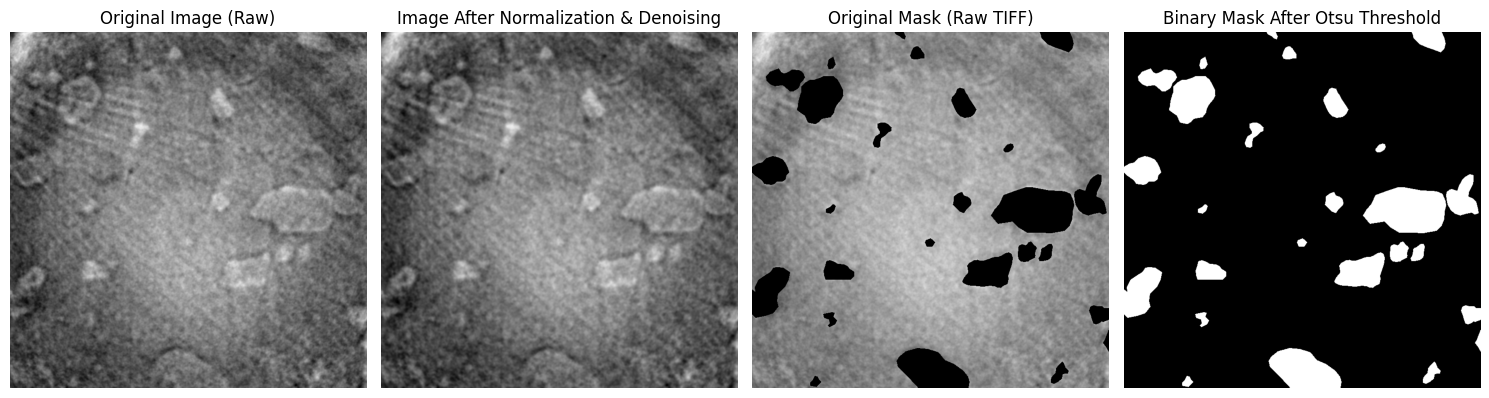

In [9]:
# Labelled image to visualize
idx = np.random.randint(0, len(labelled_image_files))
image_vis1  = tiff.imread(os.path.join(labelled_images_path, labelled_image_files[idx])).astype(np.float32)
mask_vis1 = tiff.imread(os.path.join(labelled_masks_path, labelled_mask_files[idx])).astype(np.float32)

# List to hold all image tensor
labelled_image_list = []
labelled_mask_list = []
unlabelled_image_list = []

# Denoising and normalization function (adapted from week 1)
def normalize_and_denoise(img_np, sigma = 1):
        img_norm = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
        img_denoised = gaussian_filter(img_norm, sigma=sigma)
        return img_denoised

# Get each image and turn it into a tensor (we need to normalize and denoise whilst it still is in np.array form)
for img_file, mask_file in zip(labelled_image_files, labelled_mask_files):
    # Get each path for both images and maks
    img_path = os.path.join(labelled_images_path, img_file)
    mask_path = os.path.join(labelled_masks_path, mask_file)

    # We need the image to be numpy arrays to pass normalize_and_denoise
    img_original = tiff.imread(img_path).astype(np.float32)
    mask_np = tiff.imread(mask_path).astype(np.float32) # We also do it to masks to make the process easier

    # Normalization and denoising image
    img_np = normalize_and_denoise(img_original)

    # Tresholding
    binary_mask = combined_mask(img_original, mask_np)

    # Get tensors
    img_tensor = torch.tensor(img_np).unsqueeze(0)
    mask_tensor = torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0)

    # Append to our list
    labelled_image_list.append(img_tensor)
    labelled_mask_list.append(mask_tensor)

# We repeat the pre-processing process for the unlabelled data (the model should interpret the images the same way)
for image_file in unlabelled_image_files_1h:
    # Same steps as before
    unl_img_path = os.path.join(unlabelled_images_path_1h, image_file)
    img_np  = tiff.imread(unl_img_path).astype(np.float32)
    img_np = normalize_and_denoise(img_np)
    img_tensor = torch.tensor(img_np).unsqueeze(0)
    unlabelled_image_list.append(img_tensor)

for image_file in unlabelled_image_files_10min:
    # Same steps as before
    unl_img_path = os.path.join(unlabelled_images_path_10min, image_file)
    img_np  = tiff.imread(unl_img_path).astype(np.float32)
    img_np = normalize_and_denoise(img_np)
    img_tensor = torch.tensor(img_np).unsqueeze(0)
    unlabelled_image_list.append(img_tensor)

# Count images in each group
print(f"Number of labelled images: {len(labelled_image_list)}")
print(f"Number of labelled masks: {len(labelled_mask_list)}")
print(f"Number of unlabelled images: {len(unlabelled_image_list)}")

# Visualize the transformations
image_vis2 = labelled_image_list[idx].squeeze(0).numpy()
mask_vis2  = labelled_mask_list[idx].squeeze(0).numpy()

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.imshow(image_vis1, cmap='gray')
plt.title("Original Image (Raw)")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(image_vis2, cmap='gray')
plt.title("Image After Normalization & Denoising")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(mask_vis1, cmap='gray')
plt.title("Original Mask (Raw TIFF)")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(mask_vis2, cmap='gray')
plt.title("Binary Mask After Otsu Threshold")
plt.axis("off")
plt.tight_layout()
plt.show()


####
All that is left from this step is to do some data augmentation routines. We want to get as many new images as possible but don't overdo it so that the model is not overfitted to the morphology of our dataset.

In [10]:
augmented_images = []
augmented_masks  = []

def elastic_deformation(img, mask, alpha=15, sigma=1):
    # better to work with arrays!
    img_np  = img.squeeze(0).numpy()
    mask_np = mask.squeeze(0).numpy()
    shape = img_np.shape # to scale the fields

    # random displacement fields (sigma determines the range of the warp and alpha determines the strenght)
    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0])) # blank canvas
    indices = (y + dy).reshape(-1), (x + dx).reshape(-1) # new pixel locations (defines the warp)

    img_warped  = map_coordinates(img_np,  indices, order=1, mode='reflect').reshape(shape)
    mask_warped = map_coordinates(mask_np, indices, order=0, mode='reflect').reshape(shape)

    # we want tensors
    return torch.tensor(img_warped, dtype=torch.float32).unsqueeze(0), torch.tensor(mask_warped, dtype=torch.float32).unsqueeze(0)

for img, mask in zip(labelled_image_list, labelled_mask_list):
    # Horizontal flip
    img_h = torch.flip(img, dims=[2])
    mask_h = torch.flip(mask, dims=[2])
    augmented_images.append(img_h)
    augmented_masks.append(mask_h)

    # Verical flip
    img_v = torch.flip(img, dims=[1])
    mask_v = torch.flip(mask, dims=[1])
    augmented_images.append(img_v)
    augmented_masks.append(mask_v)

    # Rotation (90, 180 or 270)
    k = random.choice([1, 2, 3])
    img_r = torch.rot90(img,  k, dims=[1,2])
    mask_r = torch.rot90(mask, k, dims=[1,2])
    augmented_images.append(img_r)
    augmented_masks.append(mask_r)

    # Elastic deformation
    img_el, mask_el = elastic_deformation(img, mask, alpha=20, sigma=3)
    augmented_images.append(img_el)
    augmented_masks.append(mask_el)

labelled_image_list = labelled_image_list + augmented_images
labelled_mask_list = labelled_mask_list + augmented_masks

print(f"New number of labelled images: {len(labelled_image_list)}")
print(f"New number of labelled masks: {len(labelled_mask_list)}")

New number of labelled images: 110
New number of labelled masks: 110


#####
Some code to visualize the data augmentation procedures.

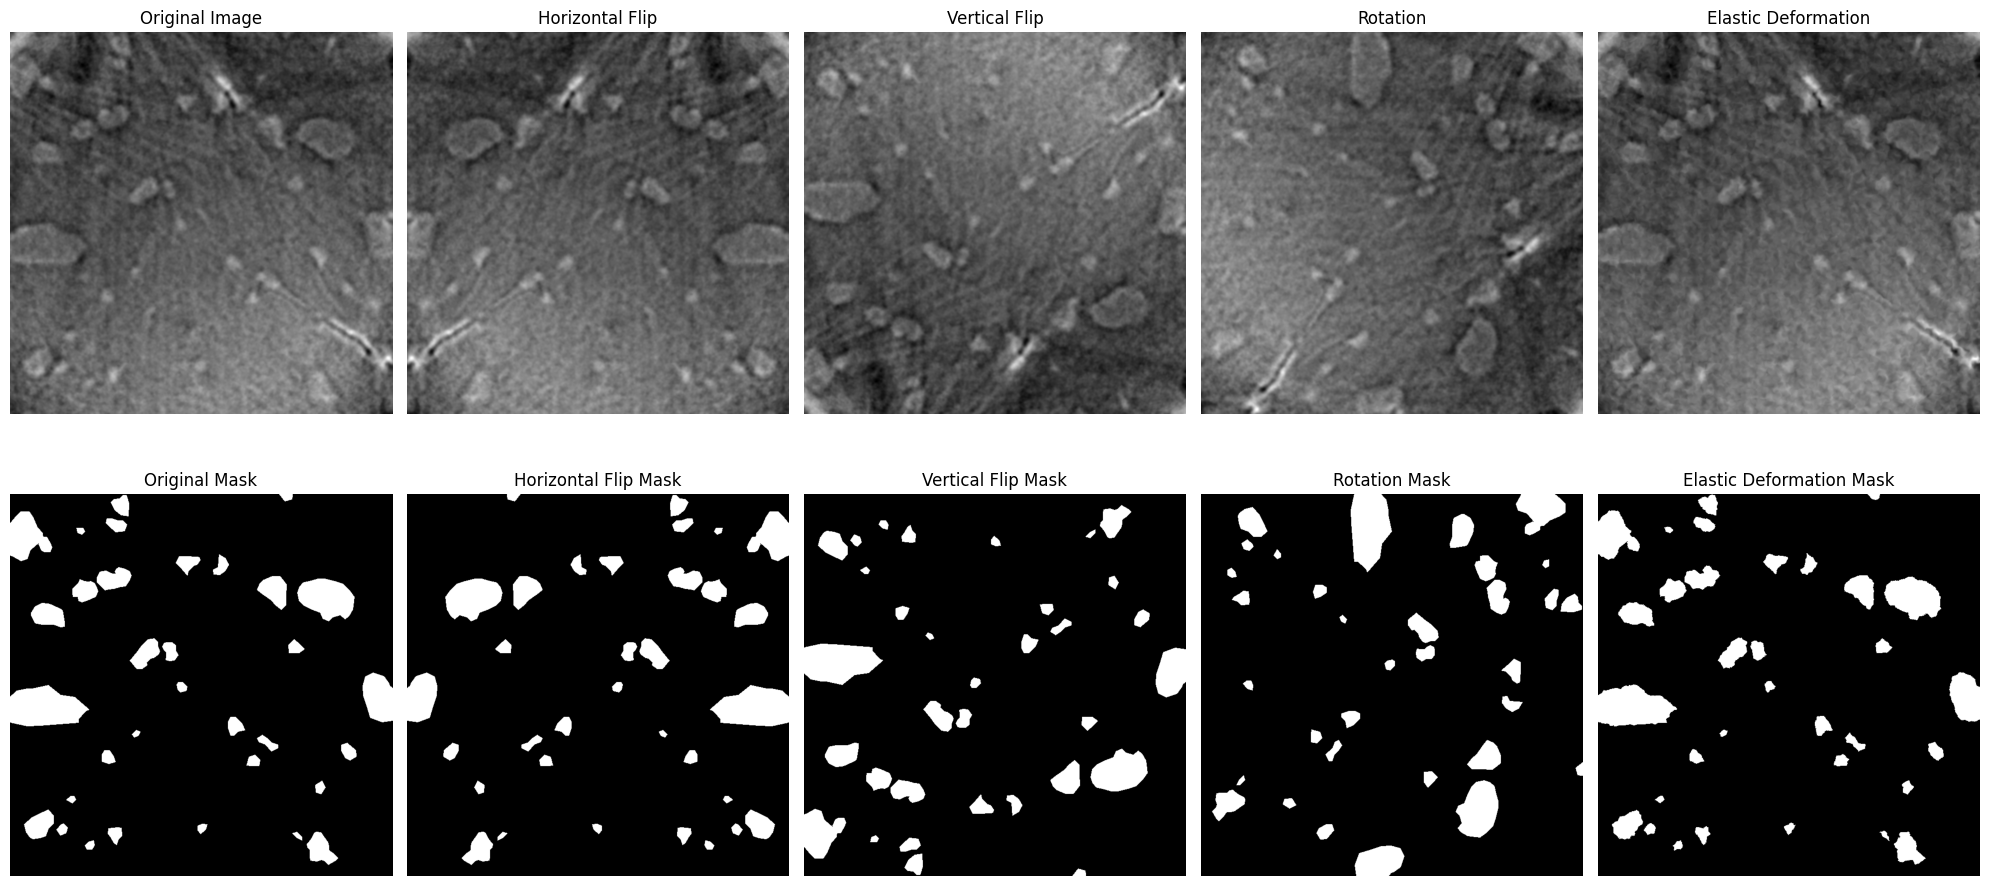

In [11]:
# Pick the first original image and mask
img_orig = labelled_image_list[0]
mask_orig = labelled_mask_list[0]

# The augmented versions of this image
img_h = augmented_images[0]
mask_h = augmented_masks[0]

img_v = augmented_images[1]
mask_v = augmented_masks[1]

img_r = augmented_images[2]
mask_r = augmented_masks[2]

img_el = augmented_images[3]
mask_el = augmented_masks[3]

# Plot
plt.figure(figsize=(20, 10))

# Original
plt.subplot(2,5,1)
plt.imshow(img_orig.squeeze(0).numpy(), cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(2,5,6)
plt.imshow(mask_orig.squeeze(0).numpy(), cmap='gray')
plt.title("Original Mask")
plt.axis("off")

# Horizontal flip
plt.subplot(2,5,2)
plt.imshow(img_h.squeeze(0).numpy(), cmap='gray')
plt.title("Horizontal Flip")
plt.axis("off")

plt.subplot(2,5,7)
plt.imshow(mask_h.squeeze(0).numpy(), cmap='gray')
plt.title("Horizontal Flip Mask")
plt.axis("off")

# Vertical flip
plt.subplot(2,5,3)
plt.imshow(img_v.squeeze(0).numpy(), cmap='gray')
plt.title("Vertical Flip")
plt.axis("off")

plt.subplot(2,5,8)
plt.imshow(mask_v.squeeze(0).numpy(), cmap='gray')
plt.title("Vertical Flip Mask")
plt.axis("off")

# Rotation
plt.subplot(2,5,4)
plt.imshow(img_r.squeeze(0).numpy(), cmap='gray')
plt.title("Rotation")
plt.axis("off")

plt.subplot(2,5,9)
plt.imshow(mask_r.squeeze(0).numpy(), cmap='gray')
plt.title("Rotation Mask")
plt.axis("off")

# Elastic deformation
plt.subplot(2,5,5)
plt.imshow(img_el.squeeze(0).numpy(), cmap='gray')
plt.title("Elastic Deformation")
plt.axis("off")

plt.subplot(2,5,10)
plt.imshow(mask_el.squeeze(0).numpy(), cmap='gray')
plt.title("Elastic Deformation Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


#### Step 2:
We already have the model from last week and data that has been preprocessed, so we can start our pseudo-labelling pipeline:

1. Fine tune the pre-trained model with the labeled images (with augmentation)

2. Generate pseudo-labelings on the unlabeled images

3. Keep only high-confidence pixeis/images (ver o que faz mais sentido) using a static/dynamic threshold (maybe testar os dois)

4. Combine labeled + pseudo datasets and continue training (weighted loss: Loss_total = L_sup(labeled) + λ * L_unsup(pseudo-labels), try different λ).

5. Iterate pseudo-labeling 1-3 times

6. Evaluate

#### 2.1. Run the model with labelled images
Now with all the data we need we can run the model that was pre-trained with the labelled data. Since we trained on a similar dataset, we only need to finetune the decoder, since feature extraction was pretty successfull on the last dataset. So we need to freeze the encoder and organize the data on DataSets and DataLoaders. A new training routine is also necessary.

In [11]:
# 70% train, 30% temp
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(labelled_image_list, labelled_mask_list, test_size=0.30, random_state=42)

# 30% split into 10% val, 20% test
val_imgs, test_imgs, val_masks, test_masks = train_test_split(temp_imgs, temp_masks, test_size=0.5714, random_state=42)

print("Train:", len(train_imgs))
print("Val:  ", len(val_imgs))
print("Test: ", len(test_imgs))

# need a dataset to compatibilize the data with the DataLoaders
class PoreDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

train_dataset = PoreDataset(train_imgs, train_masks)
val_dataset   = PoreDataset(val_imgs, val_masks)
test_dataset  = PoreDataset(test_imgs, test_masks)

# Load the data in small batches (for training routine) - images are bigger than in the SIMUPOR dataset but are fewer
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=2)
test_loader  = DataLoader(test_dataset,  batch_size=2)

Train: 77
Val:   14
Test:  19


In [26]:
# Freeze encoder (down path)
for name, param in model.named_parameters():
    if "down" in name:
        param.requires_grad = False

For the training loop, the code is heavily inspired by the one we used for the SIMUPOR dataset. We also compute loss, besides dice, for the validation because we want to be more carefull. We also compute some code to save the best model (based on dice), because it isn't always the final one.

In [27]:
# Move model to device
model = model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)  # Only update the parameters whose requires_grad == True
loss_fn = combined_loss

# Training parameters
num_epochs = 40
validation_every_steps = 10
step = 0

# For tracking metrics (we also compute the loss)
train_dice_scores = []
valid_dice_scores = []
train_losses = []
valid_losses = []

# Training routine
best_val_dice = 0.0
for epoch in range(num_epochs):
    model.train()

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        # Forward pass
        output = model(imgs)
        loss = loss_fn(output, masks)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute Dice for this batch
        preds = (torch.sigmoid(output) > 0.5).float()
        batch_dice = dice_coefficient(preds, masks)
        train_dice_scores.append(batch_dice)
        train_losses.append(loss.item())

        step += 1

        # Validation every N steps
        if step % validation_every_steps == 0:
            model.eval()
            val_dice_list = []
            val_loss_list = []

            with torch.no_grad():
                for val_imgs, val_masks in val_loader:
                    val_imgs, val_masks = val_imgs.to(device), val_masks.to(device)
                    val_output = model(val_imgs)
                    val_loss = loss_fn(val_output, val_masks)

                    val_preds = (torch.sigmoid(val_output) > 0.5).float()
                    val_dice = dice_coefficient(val_preds, val_masks)

                    val_dice_list.append(val_dice)
                    val_loss_list.append(val_loss.item())

            mean_val_dice = np.mean(val_dice_list)
            mean_val_loss = np.mean(val_loss_list)
            valid_dice_scores.append(mean_val_dice)
            valid_losses.append(mean_val_loss)

            print(f"Epoch {epoch+1}, Step {step} | Train Dice: {batch_dice:.4f} | Val Dice: {mean_val_dice:.4f} | Val Loss: {mean_val_loss:.4f}")

            # Save the best model
            if mean_val_dice > best_val_dice:
                best_val_dice = mean_val_dice
                torch.save({
                     'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'epoch': epoch+1
                 }, "/content/drive/MyDrive/dl_p21_data/fine_tuned_checkpoint.pth")

            model.train()

print("Finished training.")

Epoch 1, Step 10 | Train Dice: 0.0032 | Val Dice: 0.0010 | Val Loss: 0.6393
Epoch 1, Step 20 | Train Dice: 0.4204 | Val Dice: 0.3959 | Val Loss: 0.5020
Epoch 1, Step 30 | Train Dice: 0.3711 | Val Dice: 0.4840 | Val Loss: 0.4662
Epoch 2, Step 40 | Train Dice: 0.5417 | Val Dice: 0.4718 | Val Loss: 0.4601
Epoch 2, Step 50 | Train Dice: 0.5709 | Val Dice: 0.5146 | Val Loss: 0.4316
Epoch 2, Step 60 | Train Dice: 0.4438 | Val Dice: 0.5320 | Val Loss: 0.4228
Epoch 2, Step 70 | Train Dice: 0.5245 | Val Dice: 0.5370 | Val Loss: 0.4162
Epoch 3, Step 80 | Train Dice: 0.4229 | Val Dice: 0.5420 | Val Loss: 0.4108
Epoch 3, Step 90 | Train Dice: 0.4280 | Val Dice: 0.5134 | Val Loss: 0.4157
Epoch 3, Step 100 | Train Dice: 0.5435 | Val Dice: 0.5668 | Val Loss: 0.3890
Epoch 3, Step 110 | Train Dice: 0.5936 | Val Dice: 0.5739 | Val Loss: 0.3835
Epoch 4, Step 120 | Train Dice: 0.6115 | Val Dice: 0.5825 | Val Loss: 0.3698
Epoch 4, Step 130 | Train Dice: 0.5130 | Val Dice: 0.5753 | Val Loss: 0.3750
Epoch 4,

We test the model with the best validation dice.

In [12]:
# Uploading the weights from Drive
weights_path = "/content/drive/MyDrive/dl_p21_data/fine_tuned_checkpoint.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Creates a new model and uploads the weights to it
model = UNet(num_classes=1).to(device)

checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

print("Weights loaded successfully")

# Testing result
model.eval()
test_dice_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        preds = (torch.sigmoid(output) > 0.5).float()
        dice = dice_coefficient(preds, targets)
        test_dice_values.append(dice)

mean_test_dice = np.mean(test_dice_values)
var_test_dice  = np.var(test_dice_values)

print(f"Test dice score (mean): {mean_test_dice:.3f}       Test dice score (var): {var_test_dice:.3f}")

Weights loaded successfully
Test dice score (mean): 0.792       Test dice score (var): 0.001


#####
Some better ways to visualize the results from the training routine

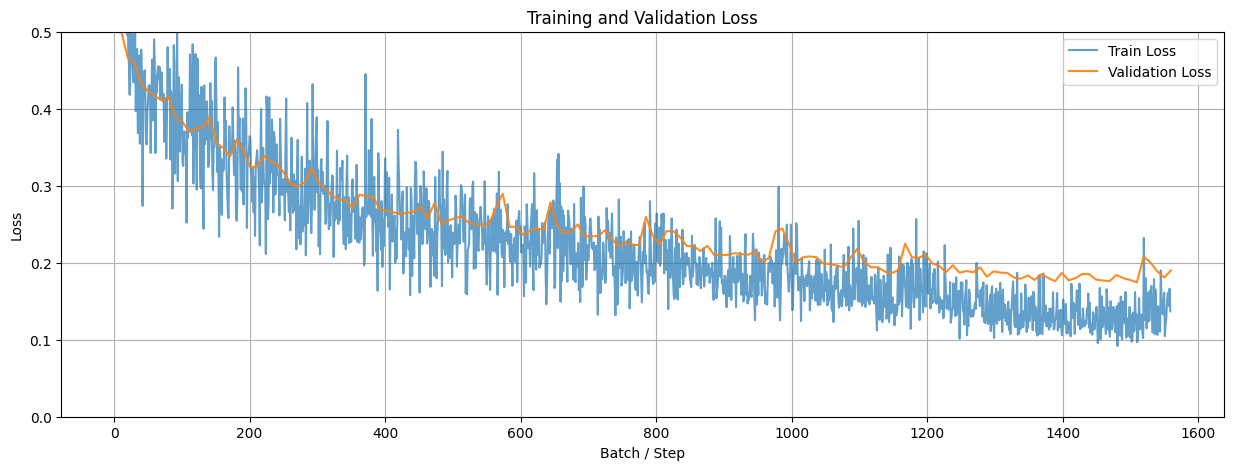

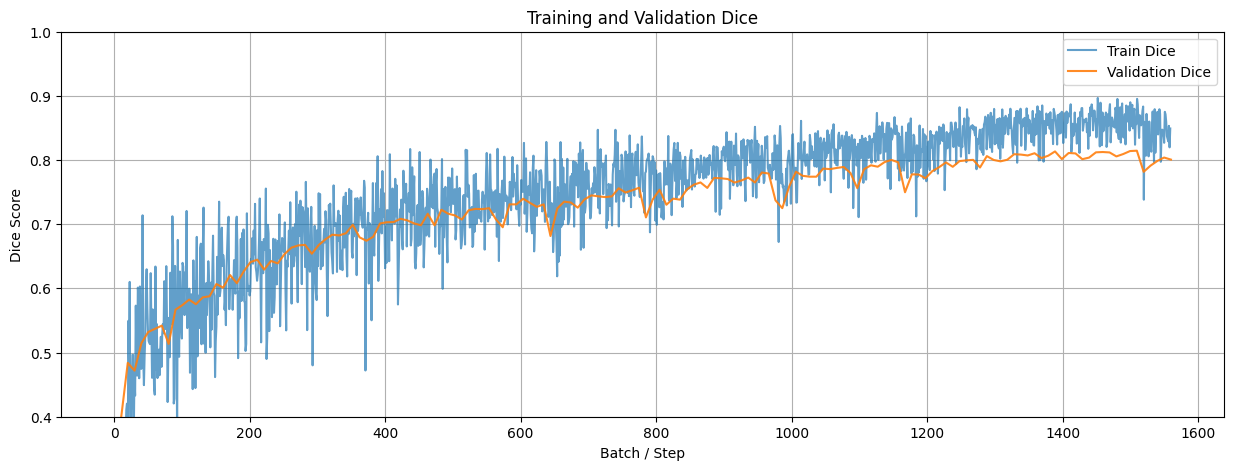

In [29]:
# Loss plot
plt.figure(figsize=(15, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(np.linspace(0, len(train_losses), len(valid_losses)), valid_losses, label='Validation Loss', alpha=0.9)
plt.xlabel('Batch / Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.ylim([0 , 0.5])
plt.show()

# Dice plot
plt.figure(figsize=(15, 5))
plt.plot(train_dice_scores, label='Train Dice', alpha=0.7)
plt.plot(np.linspace(0, len(train_dice_scores), len(valid_dice_scores)), valid_dice_scores, label='Validation Dice', alpha=0.9)
plt.xlabel('Batch / Step')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice')
plt.legend()
plt.grid(True)
plt.ylim([0.4 , 1])
plt.show()

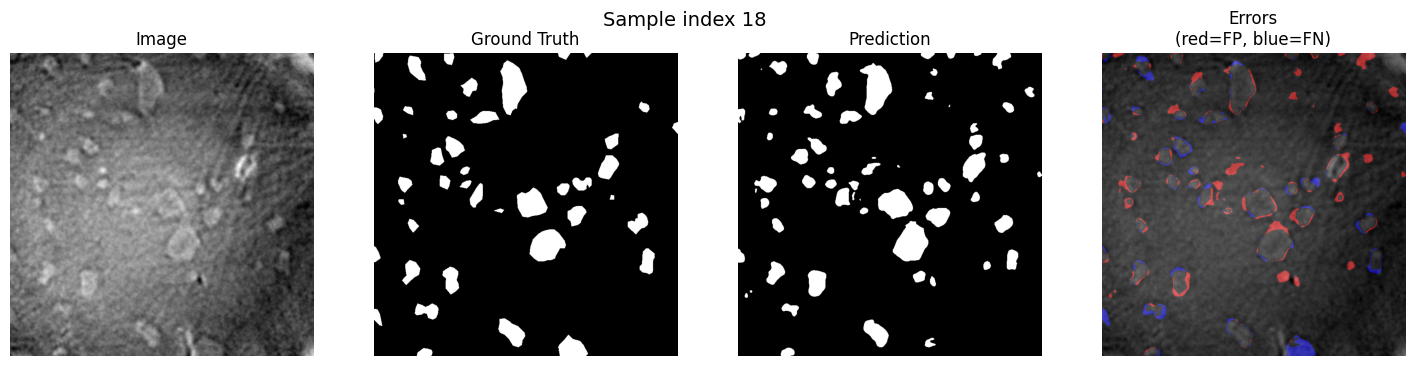

In [13]:
model.eval()

# Choose a single test sample index
idx = np.random.randint(len(test_dataset))

# Load sample
img_tensor, gt_mask = test_dataset[idx]
img = img_tensor.unsqueeze(0).to(device)

# Prediction
with torch.no_grad():
    output = model(img)
    pred = (torch.sigmoid(output) > 0.5).float().squeeze().cpu().numpy()

# Convert to numpy
img_np = img_tensor.squeeze().numpy()
gt_np  = gt_mask.squeeze().numpy()

# Intersection (True Positives)
intersection = pred * gt_np

# Error regions
false_pos = (pred == 1) & (gt_np == 0)  # red
false_neg = (pred == 0) & (gt_np == 1)  # blue

error_map = np.zeros((*gt_np.shape, 3))
error_map[false_pos] = [1, 0, 0]  # red
error_map[false_neg] = [0, 0, 1]  # blue

# Plot all 4 images
plt.figure(figsize=(18,4))
plt.suptitle(f"Sample index {idx}", fontsize=14)

# Raw image
plt.subplot(1,4,1)
plt.imshow(img_np, cmap="gray")
plt.title("Image")
plt.axis("off")

# Ground truth
plt.subplot(1,4,2)
plt.imshow(gt_np, cmap="gray")
plt.title("Mask")
plt.axis("off")

# Prediction
plt.subplot(1,4,3)
plt.imshow(pred, cmap="gray")
plt.title("Prediction")
plt.axis("off")

# Intersection + Error overlay
plt.subplot(1,4,4)
plt.imshow(img_np, cmap="gray")
plt.imshow(error_map, alpha=0.5)
plt.title("Errors\n(red=FP, blue=FN)")
plt.axis("off")

plt.show()

#### Step 2.2
Now we run the unlabelled data on the model and filter the pseudo-labels through confidence value (it only is given a label if its confidence is higher than the treshold). We should do dynamic tresholding since the model might colapse because the first samples will have very small confidence (so we increase treshold slowly as the epochs go by and model is more "confident"). Dynamic tresholding is applied along the training loop, so we need to define a function that creates pseudo-labels based on a ever changing treshold.